In [34]:
import pandas as pd  
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns; sns.set()


import re
import string

import nltk
nltk.download('punkt')
from nltk.tokenize import RegexpTokenizer
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
from wordcloud import WordCloud

from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import roc_curve, auc, classification_report
from sklearn.metrics import precision_score, recall_score, confusion_matrix, plot_confusion_matrix

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer  
from sklearn.feature_extraction.text import TfidfTransformer


from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D,Bidirectional,Dropout,GRU,Activation
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical


plt.style.use('fivethirtyeight')
%config InlineBackend.figure_format = 'retina'

[nltk_data] Downloading package punkt to C:\Users\yatharth
[nltk_data]     bansal\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
df = pd.read_csv("balanced_data_combined.csv")
df = df.drop(columns = 'Unnamed: 0')

In [3]:
print(df.shape)
df.head()

(8337, 2)


,text,class
0,Drasko they didn't cook half a bird you idiot ...,1
1,Hopefully someone cooks Drasko in the next ep ...,1
2,of course you were born in serbia...you're as ...,1
3,These girls are the equivalent of the irritati...,1
4,RT @YesYoureRacist: At least you're only a tin...,1


In [4]:
# class 0 - not hate speech
# class 1 - hate speech

In [5]:
# Crreate class description for each row in data
df['class_descr'] = df['class'].map(lambda x: 'hate_speech' if x==1 else 'not_hate_speech')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8337 entries, 0 to 8336
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   text         8335 non-null   object
 1   class        8337 non-null   int64 
 2   class_descr  8337 non-null   object
dtypes: int64(1), object(2)
memory usage: 195.5+ KB


In [7]:
# Drop NaN values in text column

df.dropna(subset=['text'], inplace=True)

# Visualize Amount of  tweets classes

c:\users\yatharth bansal\.conda\envs\nlp1\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


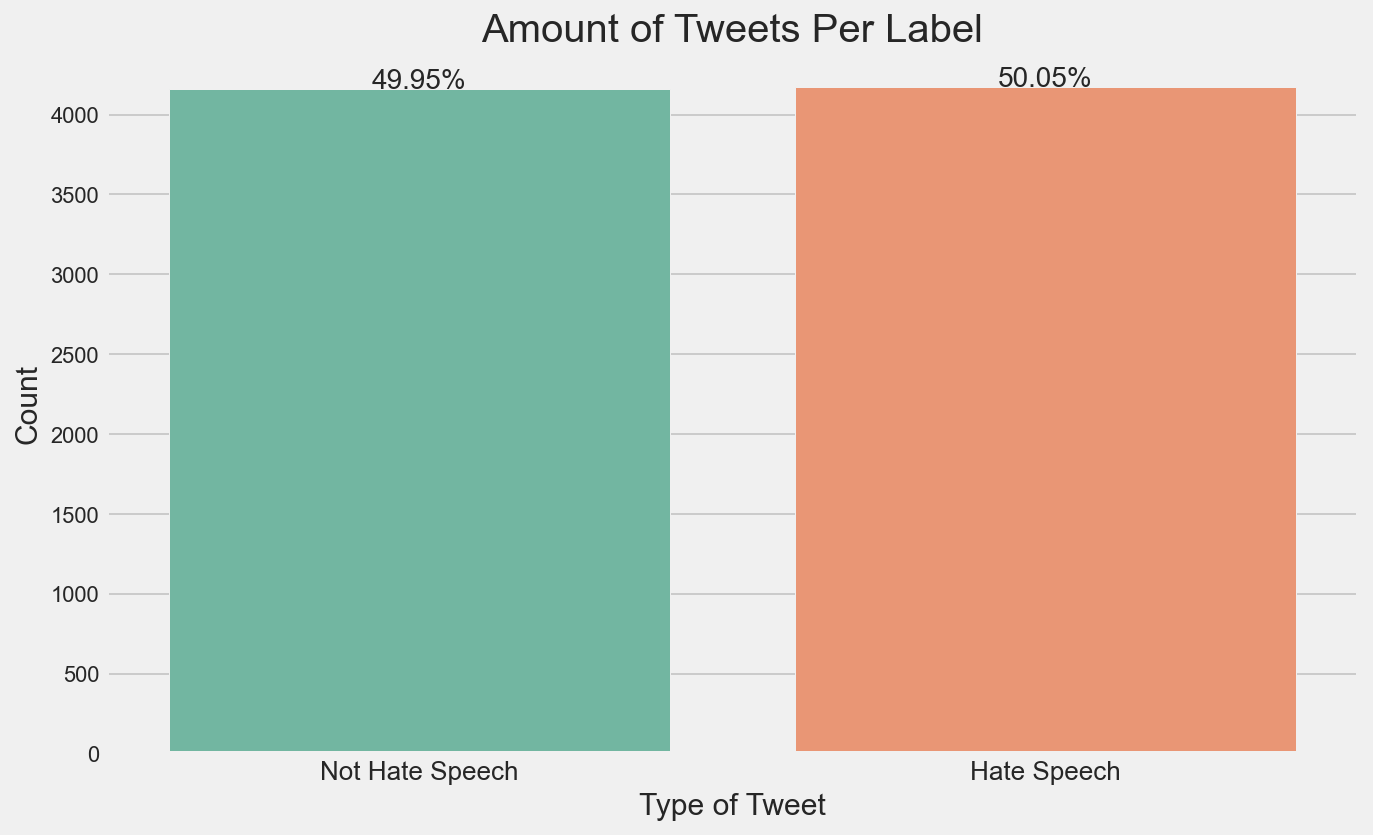

In [8]:
#print(df['class'].value_counts(normalize=True))

# Class Imbalance 

fig, ax = plt.subplots(figsize=(10,6))
ax = sns.countplot(df['class'], palette='Set2')

ax.set_title('Amount of Tweets Per Label',fontsize = 20)
ax.set_xlabel('Type of Tweet',fontsize = 15)
ax.set_ylabel('Count',fontsize = 15)
ax.set_xticklabels(['Not Hate Speech','Hate Speech'],fontsize = 13)

total = float(len(df)) # one person per row 
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}'.format(height/total * 100) + '%',
            ha="center") 

# Create Document - Term Matrix

* Preprotcessing and cleaning 
* Tokenize
* Stemming and Lemming
* Document-Term Matrix

## Data Preprotcessing and Cleaning

In [9]:
# removing excess
# removing punctuation
# lovercase letters 
# remove numbers or numerical values
# remove non-sesial text (/n)

In [10]:
# Create function with text cleaning techniques usinx regex

def clean_text_step1(text):
    '''
    Looking for speciffic patterns in the text and 
    removing them or replacing with space
    Function returns string
    '''
        
    # make text lowercase
    text = text.lower()
    
    # string punctuations
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    
    # removing patterns and replace it with nothing
    text = re.sub('\[.*?\]', '', text)
 
    # removing digits if they surounded with text or digit
    text = re.sub('\w*\d\w*', '', text)
    
    # make just 1 space if there is more then 1
    text = re.sub('\s+', ' ', text)
    
    # replace new line symbol with space
    text = re.sub('\n', ' ', text)
    
    # removing any quotes
    text = re.sub('\"+', '', text)
    
    # removing &amp;
    text = re.sub('(\&amp\;)', '', text)
    
    # cleaning from user name
    text = re.sub('(@[^\s]+)', '', text)
    
    # looking for # and replacing it
    text = re.sub('(#[^\s]+)', '', text)
    
    # removing `rt`
    text = re.sub('(rt)', '', text)

    # looking for `httptco`
    text = re.sub('(httptco)', '', text)
    
    # looking for `mkr`
    text = re.sub('(mkr)', '', text)
    
    text = re.sub('(sexist)', '', text)
    
    text = re.sub('(like)', '', text)
    
    text = re.sub('(women)', '', text)

    return text

In [11]:
# applying function for cleaning text data

df['text'] = df['text'].apply(clean_text_step1)

In [12]:
df.head()

,text,class,class_descr
0,drasko they didnt cook half a bird you idiot,1,hate_speech
1,hopefully someone cooks drasko in the next ep of,1,hate_speech
2,of course you were born in serbiayoure as fuck...,1,hate_speech
3,these girls are the equivalent of the irritati...,1,hate_speech
4,yesyoureracist at least youre only a tiny bit...,1,hate_speech


In [13]:
# Function to filter data with words that contain more then 2 characters
def txt_filtering(row, n =2):
    new_words = []
    for w in row['text'].split(' '):
        if len(w) > 2:
            new_words.append(w)
    row['text'] = ' '.join(new_words)
    return row

In [14]:
df = df.apply(txt_filtering, axis = 1)

In [15]:
df1=df

In [16]:
df2=df

## Tokenization Data (splitting into smaller pieces) and removing stopwords

In [15]:
stopwords_list = stopwords.words('english')

In [16]:
def tokenize_text(text):
    
    """
    Tocanize document and create visualization of most recent words
    Wiil filter data with stopwords
    """
    tokens = nltk.word_tokenize(text)
    
    stopwords_removed = [token for token in tokens if token not in stopwords_list] 
    
    return stopwords_removed

In [17]:
processed_data = list(map(tokenize_text, df['text']))

## Lets Plot frequency distribution of tokens in corpus

In [18]:
def plot_frequency(data):
    """
    Ploting words frequency distribution
    from corpus. data should be list of lists with strings
    """
    words_lst = []
    for tweet in data:
        for word in tweet:
            words_lst.append(word)

    fdist = FreqDist(words_lst)
    plt.figure(figsize=(10,6))
    fdist.plot(30, title = "Frequency distribution of words within corpus")
    plt.show()

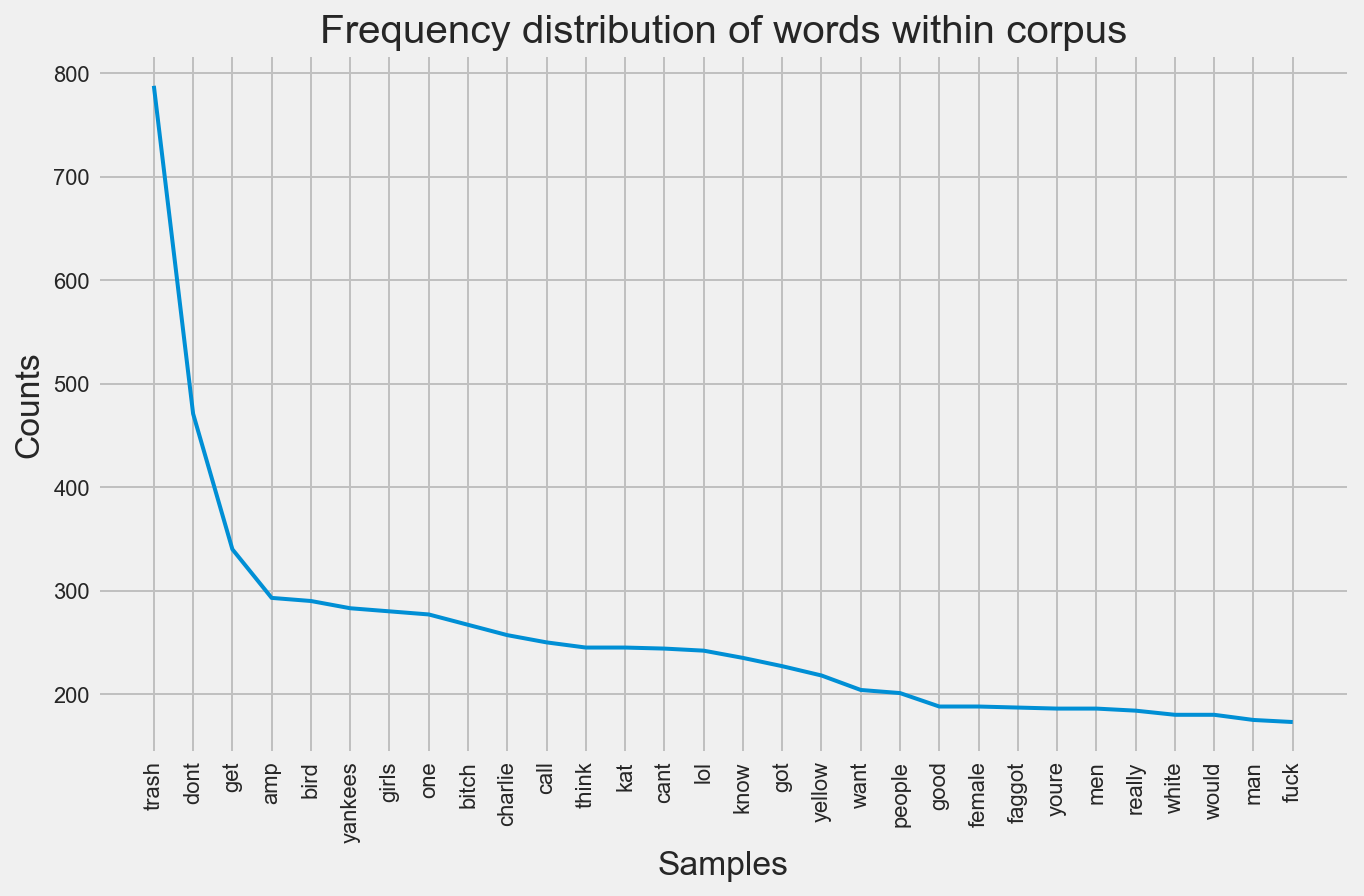

In [19]:
plot_frequency(processed_data)

In [20]:
processed_data[:2]

[['drasko', 'didnt', 'cook', 'half', 'bird', 'idiot'],
 ['hopefully', 'someone', 'cooks', 'drasko', 'next']]

In [21]:
total_vocab = set()
for tweet in processed_data:
    total_vocab.update(tweet)
len(total_vocab)

17984

## Create Docunent-Term Matrix

In [22]:
# look at the corpus
df.head()

,text,class,class_descr
0,drasko they didnt cook half bird you idiot,1,hate_speech
1,hopefully someone cooks drasko the next,1,hate_speech
2,course you were born serbiayoure fucked serbia...,1,hate_speech
3,these girls are the equivalent the irritating ...,1,hate_speech
4,yesyoureracist least youre only tiny bit racis...,1,hate_speech


In [23]:
# Using CountVextorizer from sklearn 
# in data_dtm each row represents different document
# and each collumn represents word from vocab

cv = CountVectorizer(stop_words = 'english')
df_cv = cv.fit_transform(df.text)
data_dtm = pd.DataFrame(df_cv.toarray(), columns= cv.get_feature_names())
data_dtm.index = df.index
data_dtm.head()

,aaaaaaaaand,aaand,aamaadmipay,aamattyhealy,aamessinger,aan,aandapples,aap,aarcayne,aaron,...,zstonecipher,ztsupreme,zucchini,zwaaad,zwithr,zyhosbrfff,zzachbarness,zzzquil,zzzz,zzzzzz
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Lematizing Data

In [24]:
# function to creat a list with all lemmatized words

def lematizing_text(data):
    
    """
    Lematizing words from the corpus data
    Returns list of strings with lematized 
    words in each string
    """
    
    lemmatizer = WordNetLemmatizer() 
    lemmatized_output = []

    for tweet in data:
        lemmed = ' '.join([lemmatizer.lemmatize(w) for w in tweet])
        lemmatized_output.append(lemmed)
        
    return lemmatized_output

In [25]:
lemmatized_data = lematizing_text(processed_data)

In [26]:
lemmatized_data[:5]

['drasko didnt cook half bird idiot',
 'hopefully someone cook drasko next',
 'course born serbiayoure fucked serbian film',
 'girl equivalent irritating asian girl couple year ago well done',
 'yesyoureracist least youre tiny bit racist racist dick']

## Most Frequent Words for Each Class

In [27]:
df_freq_hate = df[df['class']==1]
df_freq_not_hate = df[df['class']==0]

In [28]:
data_hate = df_freq_hate['text']
data_not_hate = df_freq_not_hate['text']

In [29]:
def freq_wrds_class(data, n = 20, show= True):
    
    """
    Returns list of 2 tuples that represents frequency
    of words in document
    
    data - Series with string data
    n - number of most common words to show
    """
    
    protc_data = list(map(tokenize_text, data))
    
    total_vocab = set()
    for comment in protc_data:
        total_vocab.update(comment)
    
    if show:
        print('Total words in vocab : {}'.format(len(total_vocab)))
        print (30*'-')
        print('Top {} most frequent words:'.format(n))
        flat_data = [item for sublist in protc_data for item in sublist]
        freq = FreqDist(flat_data)
        return freq.most_common(n)
    flat_data = [item for sublist in protc_data for item in sublist]
    freq = FreqDist(flat_data)
    
    return freq

In [30]:
# Top 20 hate words:
freq_wrds_class(data_hate, show=True)

Total words in vocab : 9703
------------------------------
Top 20 most frequent words:


[('dont', 302),
 ('bitch', 257),
 ('girls', 245),
 ('kat', 244),
 ('call', 210),
 ('get', 196),
 ('faggot', 187),
 ('think', 178),
 ('female', 176),
 ('fuck', 173),
 ('cant', 170),
 ('men', 165),
 ('ass', 152),
 ('one', 147),
 ('know', 146),
 ('nigga', 139),
 ('woman', 137),
 ('white', 133),
 ('fucking', 132),
 ('hate', 128)]

In [31]:
# Top 20 non-hate words:
freq_wrds_class(data_not_hate)

Total words in vocab : 11672
------------------------------
Top 20 most frequent words:


[('trash', 672),
 ('bird', 287),
 ('yankees', 281),
 ('charlie', 257),
 ('yellow', 213),
 ('dont', 169),
 ('birds', 167),
 ('amp', 166),
 ('get', 144),
 ('lol', 140),
 ('got', 131),
 ('one', 130),
 ('monkey', 111),
 ('ghetto', 109),
 ('colored', 108),
 ('good', 94),
 ('know', 89),
 ('new', 88),
 ('love', 84),
 ('day', 84)]

## Normalized word frequencies:

In [32]:
def normalized_word_fqncy(data, n=25):
    
    frqncy = freq_wrds_class(data, n, show = False)
    total_w_count = sum(frqncy.values())
    top = frqncy.most_common(25)
    print("Word \t\t Normalized Frequency")
    print()
    for word in top:
        normalized_frequency = word[1]/total_w_count
        print("{} \t\t {:.4}".format(word[0], normalized_frequency))

In [33]:
normalized_word_fqncy(data_hate)

Word 		 Normalized Frequency

dont 		 0.009045
bitch 		 0.007697
girls 		 0.007338
kat 		 0.007308
call 		 0.006289
get 		 0.00587
faggot 		 0.005601
think 		 0.005331
female 		 0.005271
fuck 		 0.005181
cant 		 0.005091
men 		 0.004942
ass 		 0.004552
one 		 0.004403
know 		 0.004373
nigga 		 0.004163
woman 		 0.004103
white 		 0.003983
fucking 		 0.003953
hate 		 0.003834
amp 		 0.003804
youre 		 0.003684
want 		 0.003624
people 		 0.003594
trash 		 0.003474


In [34]:
normalized_word_fqncy(data_not_hate)

Word 		 Normalized Frequency

trash 		 0.01933
bird 		 0.008254
yankees 		 0.008081
charlie 		 0.007391
yellow 		 0.006126
dont 		 0.00486
birds 		 0.004803
amp 		 0.004774
get 		 0.004141
lol 		 0.004026
got 		 0.003768
one 		 0.003739
monkey 		 0.003192
ghetto 		 0.003135
colored 		 0.003106
good 		 0.002703
know 		 0.00256
new 		 0.002531
love 		 0.002416
day 		 0.002416
game 		 0.002387
want 		 0.002387
make 		 0.002358
would 		 0.00233
people 		 0.00233


# Visualization

In [35]:
# Seperate frequency of each class

hate_freq = freq_wrds_class(data_hate, show =False)
not_hate_freq = freq_wrds_class(data_not_hate, show =False)

In [36]:
# create counts of hate and not hate with values and words

hate_bar_counts = [x[1] for x in hate_freq.most_common(25)]
hate_bar_words = [x[0] for x in hate_freq.most_common(25)]

not_hate_bar_counts = [x[1] for x in not_hate_freq.most_common(25)]
not_hate_bar_words = [x[0] for x in not_hate_freq.most_common(25)]

In [37]:
# set the color of our bar graphs
color = cm.viridis_r(np.linspace(.8,.16, 30))

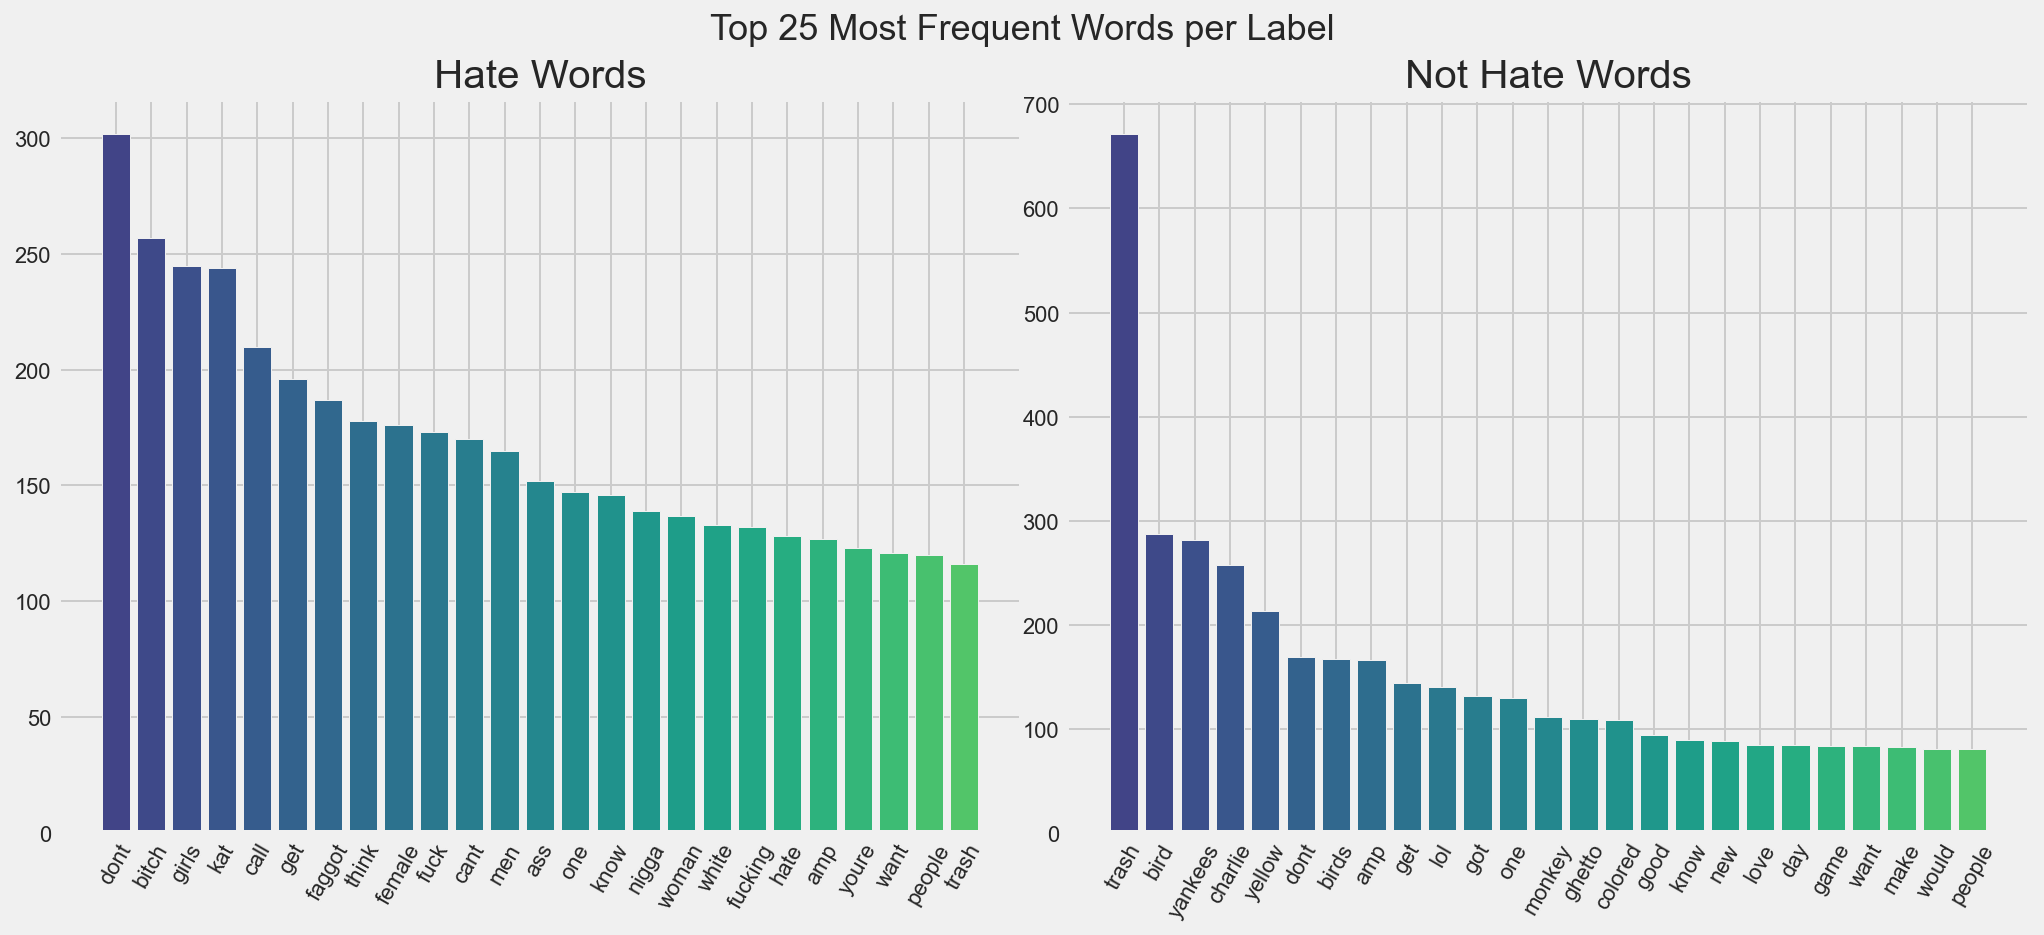

In [38]:
new_figure = plt.figure(figsize=(14,6))

ax = new_figure.add_subplot(121)
ax2 = new_figure.add_subplot(122)

# Generate a line plot on first axes
ax.bar(hate_bar_words, hate_bar_counts, color=color)
ax.plot(colormap='PRGn')

# Draw a scatter plot on 2nd axes
ax2.bar(not_hate_bar_words, not_hate_bar_counts, color=color )

ax.title.set_text('Hate Words')
ax2.title.set_text('Not Hate Words')

for ax in new_figure.axes:
    plt.sca(ax)
    plt.xticks(rotation=60)

plt.tight_layout(pad=0)
new_figure.suptitle('Top 25 Most Frequent Words per Label', fontsize =18, y =1.05)

# plt.savefig('../images/word_count_graphs.png')

plt.show()

# Create Word Clouds

In [39]:
hate_dictionary = dict(zip(hate_bar_words, hate_bar_counts))
not_hate_dictionary = dict(zip(not_hate_bar_words, not_hate_bar_counts))

In [40]:
def wordcloud(dic, save = False, name = None):
    
    
    wordcloud = WordCloud(colormap='Spectral', background_color='mintcream').generate_from_frequencies(dic)

    # Display the generated image w/ matplotlib:
    plt.figure(figsize=(8,6), facecolor='k')
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.tight_layout(pad=0)
    # plt.title('Hate Speech Word Cloud', color = "w")
    if save :
        #plt.savefig('../images/{}_wordcloud.png'.format(name))
        plt.show()
    return

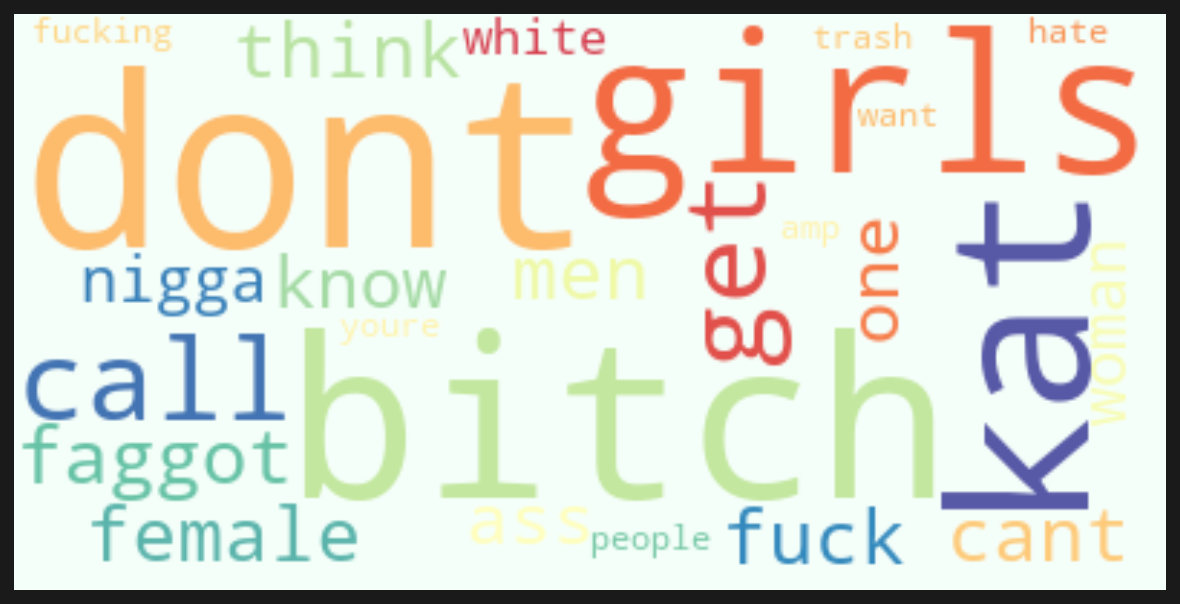

In [41]:
wordcloud(hate_dictionary, save = True, name = 'hate_speech')

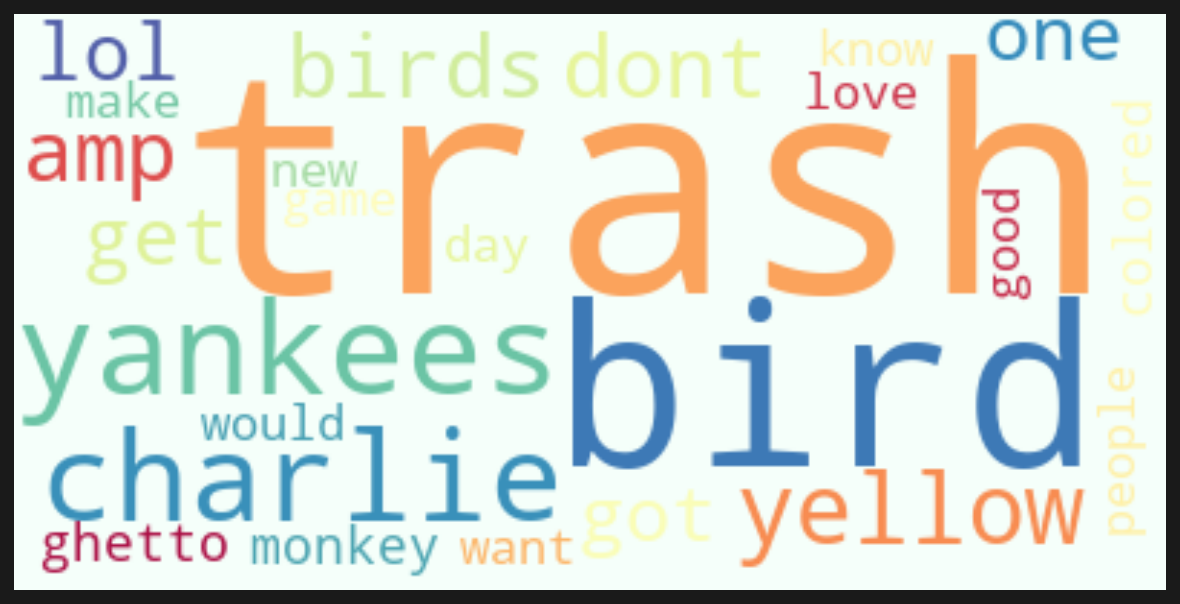

In [42]:
wordcloud(not_hate_dictionary, save = True, name = 'not_hate_speech')

## Checking unique words in both classes

In [43]:
hate_wocab = freq_wrds_class(data_hate, n = 9703)

Total words in vocab : 9703
------------------------------
Top 9703 most frequent words:


In [44]:
not_hate_wocab = freq_wrds_class(data_not_hate, n = 11672)

Total words in vocab : 11672
------------------------------
Top 11672 most frequent words:


In [45]:
hate_words = [t[0] for t in hate_wocab]
not_hate_words = [t[0] for t in not_hate_wocab]

In [46]:
exclusive_hate_wrds = [w for w in hate_words if w not in not_hate_words]
print(len(exclusive_hate_wrds))

6312


In [47]:
exclusive_hate_wrds[:10]

['faggot',
 'fuck',
 'nigga',
 'fucking',
 'niggas',
 'bitches',
 'feminists',
 'niggers',
 'yesyoure',
 'feminist']

In [48]:
len(set(exclusive_hate_wrds))

6312

As we can see a majority of hate speech words are racist, sexist and homophobic slurs that exceed cultural slang. The fact that these words are unique to the "Hate Speech" label affirm that it's indeed hate speech that should be flagged and taken down.

# Create Baseline Models 

In [49]:
X_lem = lemmatized_data
y_lem = df['class']

In [50]:
X_train_lem, X_test_lem, y_train_lem, y_test_lem = train_test_split(X_lem, y_lem, test_size=0.20, random_state=1)
tfidf = TfidfVectorizer()  # can add unigram , add stop words possible

tfidf_data_train_lem = tfidf.fit_transform(X_train_lem)  # make sure in train
tfidf_data_test_lem = tfidf.transform(X_test_lem)   # make sure on test

tfidf_data_train_lem

<6668x14428 sparse matrix of type '<class 'numpy.float64'>'
	with 53078 stored elements in Compressed Sparse Row format>

In [51]:
non_zero_cols = tfidf_data_train_lem.nnz / float(tfidf_data_train_lem.shape[0])
print("Average Number of Non-Zero Elements in Vectorized Tweets: {}".format(non_zero_cols))

percent_sparse = 1 - (non_zero_cols / float(tfidf_data_train_lem.shape[1]))
print('Percentage of columns containing ZERO: {}'.format(percent_sparse))

Average Number of Non-Zero Elements in Vectorized Tweets: 7.960107978404319
Percentage of columns containing ZERO: 0.9994482874980313


### 99.9% of the columns contain a zero, meaning that's a very sparse matrix

In [52]:
# Lets Keep All models Results in dictionary for future visualization
eval_metrics_dict = {}

## Random Forest Baseline

In [53]:
rf_classifier_lem = RandomForestClassifier(n_estimators=100, random_state=0)
rf_classifier_lem.fit(tfidf_data_train_lem, y_train_lem)
rf_test_preds_lem = rf_classifier_lem.predict(tfidf_data_test_lem)

In [54]:
rf_precision = precision_score(y_test_lem, rf_test_preds_lem)
rf_recall = recall_score(y_test_lem, rf_test_preds_lem)
rf_acc_score = accuracy_score(y_test_lem, rf_test_preds_lem)
rf_f1_score = f1_score(y_test_lem, rf_test_preds_lem)
print('Random Forest with Lemmatization Features:')

print('Precision: {:.4}'.format(rf_precision))
print('Recall: {:.4}'.format(rf_recall))

print("Testing Accuracy: {:.4}".format(rf_acc_score))
print("F1 Score: {:.4}".format(rf_f1_score))

Random Forest with Lemmatization Features:
Precision: 0.854
Recall: 0.9285
Testing Accuracy: 0.886
F1 Score: 0.8897


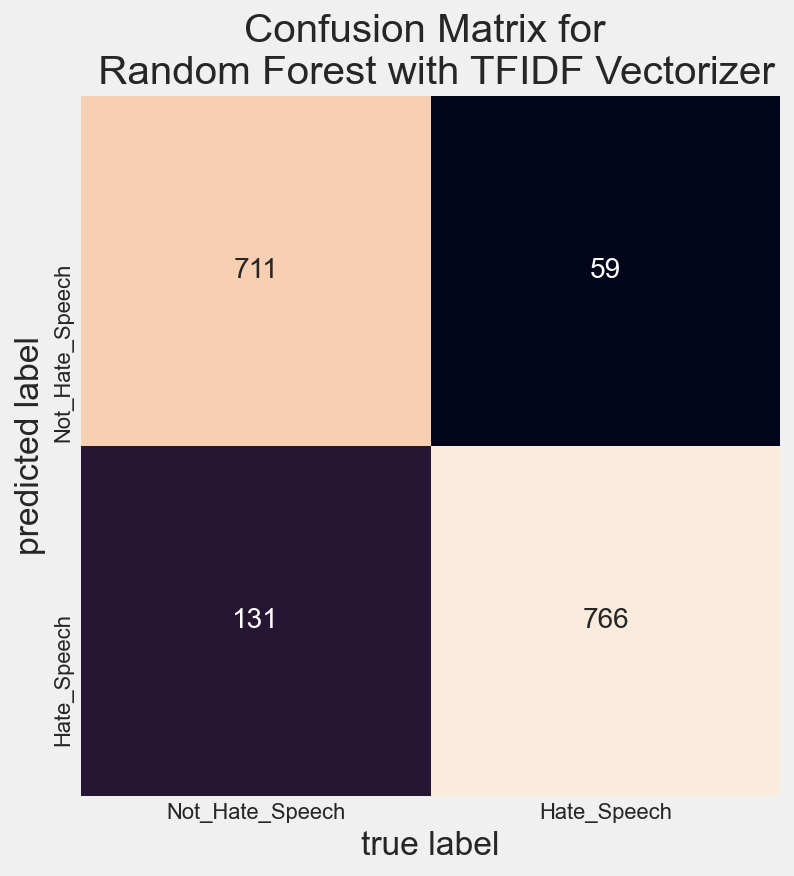

In [55]:
fig, ax = plt.subplots(figsize=(6,6))
mat = confusion_matrix(y_test_lem, rf_test_preds_lem)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=['Not_Hate_Speech', 'Hate_Speech'], yticklabels=['Not_Hate_Speech', 'Hate_Speech'])
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.title('Confusion Matrix for \n Random Forest with TFIDF Vectorizer')
#plt.savefig('../images/matrix.png')
plt.show()


In [56]:
eval_metrics_dict['Random Forest Baseline'] = {'precision' : '{:.4}'.format(rf_precision), 'recall': '{:.4}'.format(rf_recall), 'f1-score': '{:.4}'.format(rf_f1_score) }

## Logistic Regression Baseline

In [57]:
logreg = LogisticRegression(random_state = 32)
logreg.fit(tfidf_data_train_lem, y_train_lem)
logreg_test_preds = logreg.predict(tfidf_data_test_lem)

In [58]:
log_precision = precision_score(y_test_lem, logreg_test_preds)
log_recall = recall_score(y_test_lem, logreg_test_preds)
log_acc_score = accuracy_score(y_test_lem, logreg_test_preds)
log_f1_score = f1_score(y_test_lem, logreg_test_preds)
print('Random Forest with Lemmatization Features:')

print('Precision: {:.4}'.format(log_precision))
print('Recall: {:.4}'.format(log_recall))

print("Testing Accuracy: {:.4}".format(log_acc_score))
print("F1 Score: {:.4}".format(log_f1_score))

Random Forest with Lemmatization Features:
Precision: 0.9064
Recall: 0.8921
Testing Accuracy: 0.901
F1 Score: 0.8992


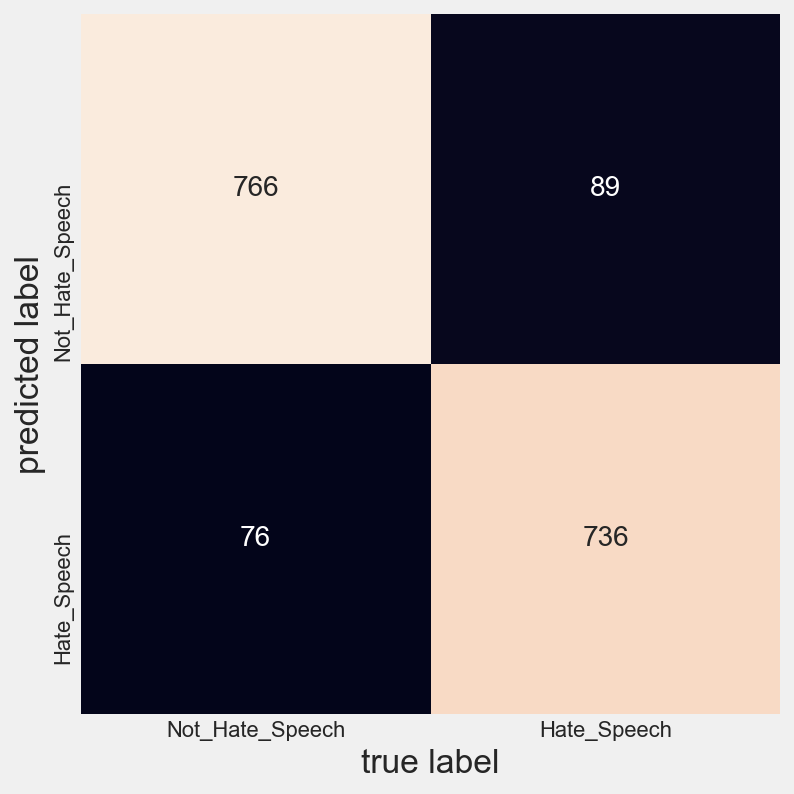

In [59]:
fig, ax = plt.subplots(figsize=(6,6))
mat = confusion_matrix(y_test_lem, logreg_test_preds)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=['Not_Hate_Speech', 'Hate_Speech'], yticklabels=['Not_Hate_Speech', 'Hate_Speech'])
plt.xlabel('true label')
plt.ylabel('predicted label');

In [60]:
eval_metrics_dict['Logistic Regression Baseline'] = {'precision' : '{:.4}'.format(log_precision), 'recall': '{:.4}'.format(log_recall), 'f1-score': '{:.4}'.format(log_f1_score) }

## Naive Bayes Baseline

In [61]:
nb = MultinomialNB()
nb.fit(tfidf_data_train_lem, y_train_lem)
nb_test_preds = nb.predict(tfidf_data_test_lem)

In [62]:
nb_precision = precision_score(y_test_lem, nb_test_preds)
nb_recall = recall_score(y_test_lem, nb_test_preds)
nb_acc_score = accuracy_score(y_test_lem, nb_test_preds)
nb_f1_score = f1_score(y_test_lem, nb_test_preds)
print('Random Forest with Lemmatization Features:')

print('Precision: {:.4}'.format(nb_precision))
print('Recall: {:.4}'.format(nb_recall))

print("Testing Accuracy: {:.4}".format(nb_acc_score))
print("F1 Score: {:.4}".format(nb_f1_score))

Random Forest with Lemmatization Features:
Precision: 0.8756
Recall: 0.9212
Testing Accuracy: 0.8962
F1 Score: 0.8978


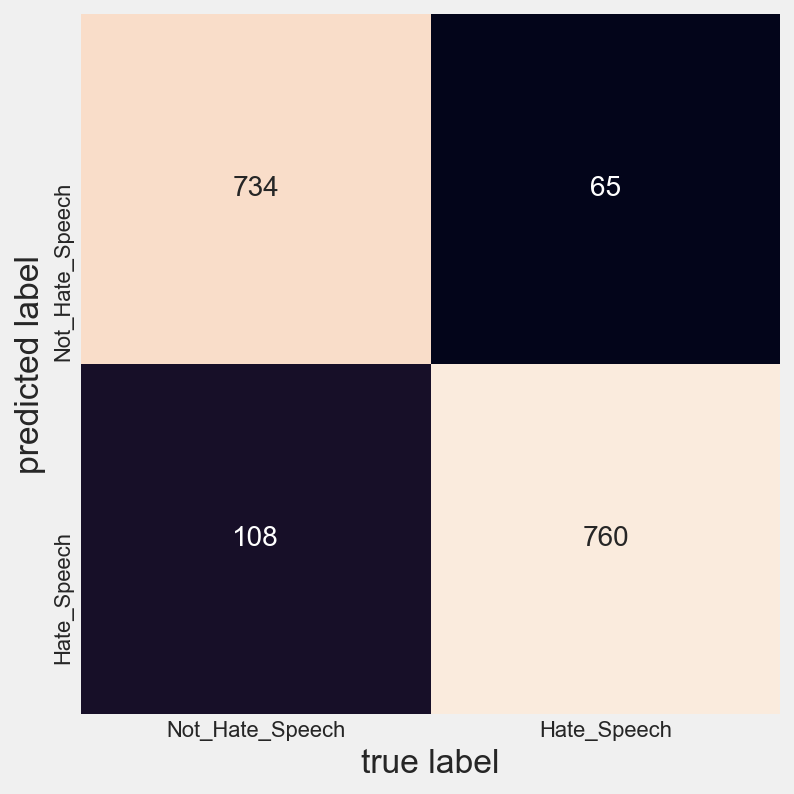

In [63]:
fig, ax = plt.subplots(figsize=(6,6))
mat = confusion_matrix(y_test_lem, nb_test_preds)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=['Not_Hate_Speech', 'Hate_Speech'], yticklabels=['Not_Hate_Speech', 'Hate_Speech'])
plt.xlabel('true label')
plt.ylabel('predicted label');

In [64]:
eval_metrics_dict['Naive Bayes Baseline'] = {'precision' : '{:.4}'.format(nb_precision), 'recall': '{:.4}'.format(nb_recall), 'f1-score': '{:.4}'.format(nb_f1_score) }

In [65]:
baseline_results = pd.DataFrame(eval_metrics_dict).T

In [66]:
baseline_results

,precision,recall,f1-score
Random Forest Baseline,0.854,0.9285,0.8897
Logistic Regression Baseline,0.9064,0.8921,0.8992
Naive Bayes Baseline,0.8756,0.9212,0.8978


## As our major evaluation metrics will be Recall and F1 score, based on models perfomance - best results was achived with Random Forest Model

# Tuning Model

In [67]:
from sklearn.model_selection import GridSearchCV

In [68]:
# Number of trees in random forrest
n_estimators = [int(x) for x in np.linspace(start = 50, stop = 200, num =5)]

# number of features to consider at each split
max_features = ['auto', 'sqrt']

# Max number of levels in tree
max_depth = [2,4]

# min number of samples required to splid the node
min_samples_split =[2,5]

# min number of samples required at each leaf node
min_samples_leaf =[1,2]

#Method of selecting samples for training each tree
# bootstrap =[True,False]

In [69]:
param_grid = {'n_estimators' : n_estimators,
             'max_features' : max_features,
             'max_depth' : max_depth,
             'min_samples_split' : min_samples_split,
             'min_samples_leaf' : min_samples_leaf}
             #'bootstrap' : bootstrap }
param_grid

{'n_estimators': [50, 87, 125, 162, 200],
 'max_features': ['auto', 'sqrt'],
 'max_depth': [2, 4],
 'min_samples_split': [2, 5],
 'min_samples_leaf': [1, 2]}

In [70]:
rf_momdel = RandomForestClassifier()
rf_grid = GridSearchCV(estimator = rf_momdel, param_grid = param_grid, cv = 3, verbose = 1, n_jobs = 4, scoring = 'recall' )

In [71]:
rf_grid.fit(tfidf_data_train_lem, y_train_lem)

Fitting 3 folds for each of 80 candidates, totalling 240 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=4,
             param_grid={'max_depth': [2, 4], 'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 5],
                         'n_estimators': [50, 87, 125, 162, 200]},
             scoring='recall', verbose=3)

In [72]:
rf_grid.best_params_

{'max_depth': 2,
 'max_features': 'auto',
 'min_samples_leaf': 2,
 'min_samples_split': 5,
 'n_estimators': 50}

In [73]:
rf_clf_tunned = RandomForestClassifier(n_estimators = 100, max_depth = 2, max_features = 'auto', min_samples_split=2)
rf_clf_tunned.fit(tfidf_data_train_lem, y_train_lem)
t_rf_test_preds_lem = rf_clf_tunned.predict(tfidf_data_test_lem)

In [74]:
t_rf_precision = precision_score(y_test_lem, t_rf_test_preds_lem)
t_rf_recall = recall_score(y_test_lem, t_rf_test_preds_lem)
t_rf_acc_score = accuracy_score(y_test_lem, t_rf_test_preds_lem)
t_rf_f1_score = f1_score(y_test_lem, t_rf_test_preds_lem)
print('Random Forest with Hyper Parameters selected with GridSearch:')

print('Precision: {:.4}'.format(t_rf_precision))
print('Recall: {:.4}'.format(t_rf_recall))

print("Testing Accuracy: {:.4}".format(t_rf_acc_score))
print("F1 Score: {:.4}".format(t_rf_f1_score))

Random Forest with Hyper Parameters selected with GridSearch:
Precision: 0.6733
Recall: 0.9418
Testing Accuracy: 0.7451
F1 Score: 0.7852


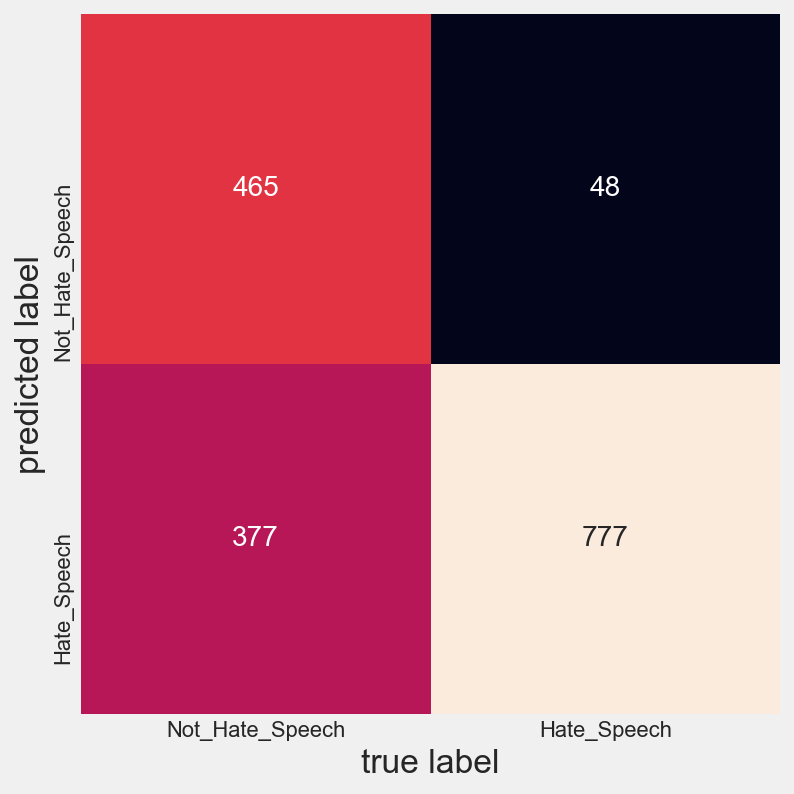

In [75]:
fig, ax = plt.subplots(figsize=(6,6))
mat = confusion_matrix(y_test_lem, t_rf_test_preds_lem)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=['Not_Hate_Speech', 'Hate_Speech'], yticklabels=['Not_Hate_Speech', 'Hate_Speech'])
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.show()

In [76]:
t_rf_train_preds_lem = rf_clf_tunned.predict(tfidf_data_train_lem)

t_rf_precision_train = precision_score(y_train_lem, t_rf_train_preds_lem)
t_rf_recall_train = recall_score(y_train_lem, t_rf_train_preds_lem)
t_rf_acc_score_train = accuracy_score(y_train_lem, t_rf_train_preds_lem)
t_rf_f1_score_train = f1_score(y_train_lem, t_rf_train_preds_lem)
print('Random Forest with Hyper Parameters selected with GridSearch:')

print('Precision: {:.4}'.format(t_rf_precision_train))
print('Recall: {:.4}'.format(t_rf_recall_train))

print("Training Accuracy: {:.4}".format(t_rf_acc_score_train))
print("F1 Score: {:.4}".format(t_rf_f1_score_train))

Random Forest with Hyper Parameters selected with GridSearch:
Precision: 0.712
Recall: 0.9698
Training Accuracy: 0.7879
F1 Score: 0.8211


# BERT

In [16]:
df1

,text,class,class_descr
0,drasko they didnt cook half bird you idiot,1,hate_speech
1,hopefully someone cooks drasko the next,1,hate_speech
2,course you were born serbiayoure fucked serbia...,1,hate_speech
3,these girls are the equivalent the irritating ...,1,hate_speech
4,yesyoureracist least youre only tiny bit racis...,1,hate_speech
...,...,...,...
8332,you know what they say the early bird gets the...,0,not_hate_speech
8333,youre all niggers,1,hate_speech
8334,youre such retard hope you get type diabetes a...,1,hate_speech
8335,youve gone and broke the wrong hea baby and dr...,0,not_hate_speech


In [17]:
df1.drop(columns='class',inplace=True)

In [18]:
df1

,text,class_descr
0,drasko they didnt cook half bird you idiot,hate_speech
1,hopefully someone cooks drasko the next,hate_speech
2,course you were born serbiayoure fucked serbia...,hate_speech
3,these girls are the equivalent the irritating ...,hate_speech
4,yesyoureracist least youre only tiny bit racis...,hate_speech
...,...,...
8332,you know what they say the early bird gets the...,not_hate_speech
8333,youre all niggers,hate_speech
8334,youre such retard hope you get type diabetes a...,hate_speech
8335,youve gone and broke the wrong hea baby and dr...,not_hate_speech


In [19]:
df1.shape

(8335, 2)

In [20]:
X=list(df1['text'])

In [21]:
y=list(df1['class_descr'])
y[::-1]

['not_hate_speech',
 'not_hate_speech',
 'hate_speech',
 'hate_speech',
 'not_hate_speech',
 'hate_speech',
 'not_hate_speech',
 'not_hate_speech',
 'not_hate_speech',
 'not_hate_speech',
 'not_hate_speech',
 'not_hate_speech',
 'not_hate_speech',
 'not_hate_speech',
 'not_hate_speech',
 'hate_speech',
 'not_hate_speech',
 'not_hate_speech',
 'not_hate_speech',
 'not_hate_speech',
 'not_hate_speech',
 'not_hate_speech',
 'not_hate_speech',
 'not_hate_speech',
 'not_hate_speech',
 'not_hate_speech',
 'not_hate_speech',
 'not_hate_speech',
 'not_hate_speech',
 'not_hate_speech',
 'not_hate_speech',
 'not_hate_speech',
 'not_hate_speech',
 'not_hate_speech',
 'not_hate_speech',
 'not_hate_speech',
 'not_hate_speech',
 'not_hate_speech',
 'hate_speech',
 'not_hate_speech',
 'hate_speech',
 'not_hate_speech',
 'hate_speech',
 'not_hate_speech',
 'not_hate_speech',
 'not_hate_speech',
 'not_hate_speech',
 'hate_speech',
 'not_hate_speech',
 'not_hate_speech',
 'not_hate_speech',
 'not_hate_s

In [22]:
y=pd.get_dummies(y)
y

,hate_speech,not_hate_speech
0,1,0
1,1,0
2,1,0
3,1,0
4,1,0
...,...,...
8330,0,1
8331,1,0
8332,1,0
8333,0,1


In [23]:
y.drop(columns='not_hate_speech',inplace=True)
y

,hate_speech
0,1
1,1
2,1
3,1
4,1
...,...
8330,0
8331,1
8332,1
8333,0


In [24]:
y=y['hate_speech'].values.tolist()
y

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,


In [25]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 0)

In [26]:
X_train

['mayweather pussy hes only winning cus picks his fight and picks the nobody fighters fightpacquiao floydmayweather',
 'beardednixon poont gotta trash',
 'hmmwhich the root cause their hypocrisy you have swung',
 'international law enforcement operation disrupts shylock banking malware pcworld international law enforcem',
 'beanies cumming real soon',
 'nbc news projects charlie baker wins massachusetts governor',
 'hahahahaha blonde moment',
 'thegeekchick please answer',
 'emmalouisasuttl anyone bring monkey',
 'missarahd tranny',
 'what ppl expect august aslina nig from new orleans',
 'dariendaywalt bitch shut the fuck goddam your slut bitch whore nigga',
 'whatimcraving peanut butter oreos',
 'grumpyvancouver issue with female hosts spos broadcast that most have variation tone voice not',
 'hba trash',
 'deeznutsdoe how about you wash butthole out with your tongue you little faggot',
 'everyone thinks that not the person look moles dont understand colored hair what big difference',

In [27]:
from transformers import DistilBertTokenizerFast
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

In [28]:
train_encodings = tokenizer(X_train, truncation=True, padding=True)
test_encodings = tokenizer(X_test, truncation=True, padding=True)

In [29]:
train_encodings

{'input_ids': [[101, 2089, 28949, 22418, 2002, 2015, 2069, 3045, 12731, 2015, 11214, 2010, 2954, 1998, 11214, 1996, 6343, 7299, 2954, 19498, 15549, 7113, 12305, 27871, 28949, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 23905, 3490, 22500, 13433, 12162, 10657, 11669, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 17012, 2860, 16066, 2232, 1996, 7117, 3426, 2037, 1044, 22571, 10085, 6935, 2100, 2017, 2031, 7671, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 2248, 2375, 7285, 3169, 23217, 2015, 11004, 7878, 8169, 15451, 8059, 7473, 11108, 2248, 2375, 16306, 2213, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 14068, 3111, 13988, 6562, 2613, 2574, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [30]:
import tensorflow as tf

train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    y_train
))

test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings),
    y_test
))

In [31]:
train_dataset

<TensorSliceDataset shapes: ({input_ids: (50,), attention_mask: (50,)}, ()), types: ({input_ids: tf.int32, attention_mask: tf.int32}, tf.int32)>

In [32]:
from transformers import TFDistilBertForSequenceClassification, TFTrainer, TFTrainingArguments

training_args = TFTrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=2,              # total number of training epochs
    per_device_train_batch_size=8,  # batch size per device during training
    per_device_eval_batch_size=16,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=10,
)

In [33]:
with training_args.strategy.scope():
    model = TFDistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased")

trainer = TFTrainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=test_dataset             # evaluation dataset
)

trainer.train()

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['activation_13', 'vocab_layer_norm', 'vocab_projector', 'vocab_transform']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier', 'dropout_19', 'pre_classifier']
You should probably TRAIN this model on a down-stream task to be able to use i

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


In [34]:
trainer.evaluate(test_dataset)

{'eval_loss': 0.22402917771112352}

In [35]:
predictions=trainer.predict(test_dataset)

In [57]:
predictions[1]

array([0, 1, 1, ..., 0, 0, 0])

In [38]:
y_test

[0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,


In [56]:
bert_precision = precision_score(y_test, predictions[1])
bert_recall = recall_score(y_test, predictions[1])
bert_acc_score = accuracy_score(y_test, predictions[1])
bert_f1_score = f1_score(y_test, predictions[1])
print('BERT')

print('Precision: {:.4}'.format(bert_precision))
print('Recall: {:.4}'.format(bert_recall))

print("Testing Accuracy: {:.4}".format(bert_acc_score))
print("F1 Score: {:.4}".format(bert_f1_score))

BERT
Precision: 1.0
Recall: 1.0
Testing Accuracy: 1.0
F1 Score: 1.0


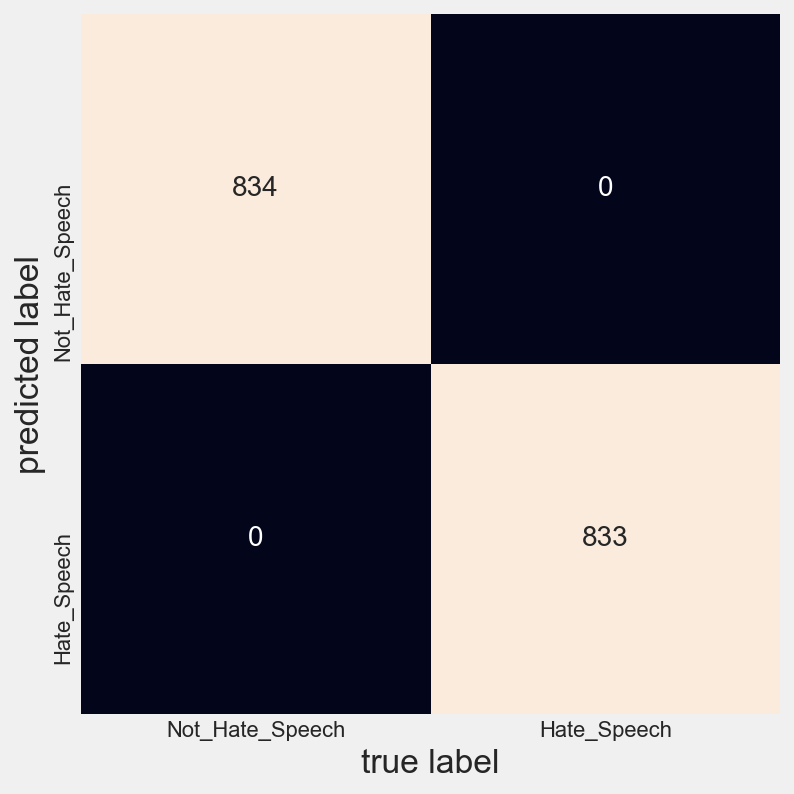

In [62]:
fig, ax = plt.subplots(figsize=(6,6))
mat = confusion_matrix(y_test,predictions[1])
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=['Not_Hate_Speech', 'Hate_Speech'], yticklabels=['Not_Hate_Speech', 'Hate_Speech'])
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.show()

# LSTM

In [17]:
df2

,text,class,class_descr
0,drasko they didnt cook half bird you idiot,1,hate_speech
1,hopefully someone cooks drasko the next,1,hate_speech
2,course you were born serbiayoure fucked serbia...,1,hate_speech
3,these girls are the equivalent the irritating ...,1,hate_speech
4,yesyoureracist least youre only tiny bit racis...,1,hate_speech
...,...,...,...
8332,you know what they say the early bird gets the...,0,not_hate_speech
8333,youre all niggers,1,hate_speech
8334,youre such retard hope you get type diabetes a...,1,hate_speech
8335,youve gone and broke the wrong hea baby and dr...,0,not_hate_speech


In [18]:
df2.drop(columns='class_descr',inplace=True)

In [19]:
df2

,text,class
0,drasko they didnt cook half bird you idiot,1
1,hopefully someone cooks drasko the next,1
2,course you were born serbiayoure fucked serbia...,1
3,these girls are the equivalent the irritating ...,1
4,yesyoureracist least youre only tiny bit racis...,1
...,...,...
8332,you know what they say the early bird gets the...,0
8333,youre all niggers,1
8334,youre such retard hope you get type diabetes a...,1
8335,youve gone and broke the wrong hea baby and dr...,0


In [20]:
tokenizer = Tokenizer(num_words=1500, split=' ')

tokenizer.fit_on_texts(df2['text'].values)

X = tokenizer.texts_to_sequences(df2['text'])

X = pad_sequences(X)

In [21]:
y=df2['class']
y

0       1
1       1
2       1
3       1
4       1
       ..
8332    0
8333    1
8334    1
8335    0
8336    0
Name: class, Length: 8335, dtype: int64

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.15, random_state = 42)

In [23]:
max_features=20000
model = Sequential()
model.add(Embedding(max_features, 128))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

In [24]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [25]:
batch_size = 36
model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=20,
          validation_data=(X_test, y_test))

Epoch 1/20
197/197 [==============================] - 30s 57ms/step - loss: 0.5434 - accuracy: 0.7026 - val_loss: 0.2434 - val_accuracy: 0.8985
Epoch 2/20
197/197 [==============================] - 10s 50ms/step - loss: 0.2061 - accuracy: 0.9199 - val_loss: 0.2307 - val_accuracy: 0.9041
Epoch 3/20
197/197 [==============================] - 10s 51ms/step - loss: 0.1556 - accuracy: 0.9384 - val_loss: 0.2443 - val_accuracy: 0.8961
Epoch 4/20
197/197 [==============================] - 10s 51ms/step - loss: 0.1327 - accuracy: 0.9454 - val_loss: 0.2658 - val_accuracy: 0.8865
Epoch 5/20
197/197 [==============================] - 11s 55ms/step - loss: 0.1203 - accuracy: 0.9501 - val_loss: 0.2697 - val_accuracy: 0.8865
Epoch 6/20
197/197 [==============================] - 11s 57ms/step - loss: 0.1028 - accuracy: 0.9634 - val_loss: 0.3023 - val_accuracy: 0.8897
Epoch 7/20
197/197 [==============================] - 11s 54ms/step - loss: 0.0880 - accuracy: 0.9636 - val_loss: 0.3921 - val_accuracy:

In [26]:
score, acc = model.evaluate(X_test, y_test,
                            batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)

35/35 [==============================] - 0s 4ms/step - loss: 0.8303 - accuracy: 0.8665
Test score: 0.8302688002586365
Test accuracy: 0.866506814956665


# Bi-Directional LSTM

In [27]:
max_features = 20000
batch_size = 32
maxlen=100


In [28]:
model1 = Sequential()
model1.add(Embedding(max_features, 128, input_length=maxlen))
model1.add(Bidirectional(LSTM(64)))
model1.add(Dropout(0.5))
model1.add(Dense(1, activation='sigmoid'))

In [29]:
model1.compile('adam', 'binary_crossentropy', metrics=['accuracy'])

In [30]:
model1.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=10,
          validation_data=[X_test, y_test])

Epoch 1/10
222/222 [==============================] - 13s 37ms/step - loss: 0.5709 - accuracy: 0.6648 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/10
222/222 [==============================] - 8s 35ms/step - loss: 0.2132 - accuracy: 0.9128 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 3/10
222/222 [==============================] - 8s 35ms/step - loss: 0.1564 - accuracy: 0.9356 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 4/10
222/222 [==============================] - 8s 35ms/step - loss: 0.1234 - accuracy: 0.9528 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 5/10
222/222 [==============================] - 8s 35ms/step - loss: 0.1059 - accuracy: 0.9609 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 6/10
222/222 [==============================] - 8s 34ms/step - loss: 0.0876 - accuracy: 0.9654 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 7/10
222/222 [==============================] - 8s 35ms/step - loss: 0.0797 - accuracy:

In [31]:
score, acc = model1.evaluate(X_test, y_test,
                            batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)

40/40 [==============================] - 1s 4ms/step - loss: 0.4525 - accuracy: 0.8777
Test score: 0.4525492787361145
Test accuracy: 0.8776978254318237


# GRU(Gated Recurrent Unit) Network

In [32]:
num_words = 30000
maxlen = 300


In [38]:
X_train = X_train.reshape(X_train.shape + (1,))
X_test = X_test.reshape(X_test.shape + (1,))

In [45]:
def gru_model():
    model2 = Sequential()
    model2.add(GRU(50, input_shape = (300,1), return_sequences = True))
    model2.add(GRU(1, return_sequences = False))
    model2.add(Activation('sigmoid'))
    
    model2.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
    return model2
    
model2 = gru_model()

model2.fit(X_train, y_train, batch_size = 32, epochs = 20)



Epoch 1/20
222/222 [==============================] - 5s 10ms/step - loss: 0.6830 - accuracy: 0.5544
Epoch 2/20
222/222 [==============================] - 2s 10ms/step - loss: 0.6587 - accuracy: 0.6109
Epoch 3/20
222/222 [==============================] - 2s 10ms/step - loss: 0.6532 - accuracy: 0.6141
Epoch 4/20
222/222 [==============================] - 2s 10ms/step - loss: 0.6430 - accuracy: 0.6310
Epoch 5/20
222/222 [==============================] - 2s 11ms/step - loss: 0.6349 - accuracy: 0.6411
Epoch 6/20
222/222 [==============================] - 2s 11ms/step - loss: 0.6355 - accuracy: 0.6372
Epoch 7/20
222/222 [==============================] - 2s 11ms/step - loss: 0.6321 - accuracy: 0.6465
Epoch 8/20
222/222 [==============================] - 2s 10ms/step - loss: 0.6279 - accuracy: 0.6525
Epoch 9/20
222/222 [==============================] - 2s 10ms/step - loss: 0.6286 - accuracy: 0.6466
Epoch 10/20
222/222 [==============================] - 2s 10ms/step - loss: 0.6269 - accura

In [46]:
scores = model2.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 63.31%
